# Extended figure 

## Plot the PIK3CA sequenced region and the positive selection there

In [1]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress,norm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
import sys
sys.path.append('../../')
from consensus_variables import *

In [4]:
pd.set_option('display.max_columns', None)

# Define gene order and plot and data directories

In [6]:
plots_dir = "./plots"
data_dir = "./data"

In [18]:
somatic_maf = pd.read_table(somatic_maf_file)

/tmp/ipykernel_2051283/3667802186.py:1: DtypeWarning: Columns (49,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  maf_df = pd.read_table(maf_file)
/tmp/ipykernel_2051283/3667802186.py:2: DtypeWarning: Columns (49,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  somatic_maf = pd.read_table(somatic_maf_file)


In [8]:
somatic_maf_clean = somatic_maf[(somatic_maf["canonical_SYMBOL"].isin(panel_all_genes)) 
                                & (somatic_maf["TYPE"] == 'SNV')
                                & (somatic_maf["canonical_SYMBOL"] == 'PIK3CA')
                                & (~somatic_maf["FILTER.not_in_exons"])
                                & (somatic_maf['canonical_Protein_position'] != '-')
                                ].reset_index(drop = True)
somatic_maf_clean['canonical_Protein_position'] = somatic_maf_clean['canonical_Protein_position'].astype(int)

counts_per_position = somatic_maf_clean.groupby(by = ["SAMPLE_ID", "canonical_SYMBOL", 'canonical_Consequence_broader', 'canonical_Protein_position'])['ALT_DEPTH'].size().to_frame('Count').reset_index()
counts_per_position.columns = ["SAMPLE_ID", 'Gene', 'Consequence', 'Pos', 'Count']
counts_per_position.head()

,SAMPLE_ID,Gene,Consequence,Pos,Count
0,P19_0001_BDO_01,PIK3CA,missense,1047,1
1,P19_0001_BTR_01,PIK3CA,missense,1047,1
2,P19_0002_BDO_01,PIK3CA,missense,1011,1
3,P19_0002_BDO_01,PIK3CA,missense,1047,1
4,P19_0002_BTR_01,PIK3CA,missense,1024,1


In [9]:
# mutations_in_tert_promoter.groupby(by = 'MUT_ID').size().sort_values(ascending = False).head(6)

In [10]:
# mutations_in_tert_promoter[mutations_in_tert_promoter["MUT_ID"] == "chr5:1295113_G>A"].iloc[0,4]

In [11]:
def plot_count_track(count_df, 
                     gene_len,
                     axes, 
                     colors_dict,
                     ax=0, 
                     negative=False, 
                     label_pos_track=None,
                     label_neg_track=None,
                     ymargin=None,
                     alpha=1,
                     indel=False,
                     n_batches = 10
                    ):

    # Shuffle the data and split into batches
    shuffled_df = count_df.sample(frac=1, random_state=42).reset_index(drop=True)
    batches = np.array_split(shuffled_df, n_batches)

    legend_list = []
    pos_df = pd.DataFrame({"Pos" : range(1, gene_len+1)})
    
    for batch_idx, batch in enumerate(batches):
        for cnsq in [#'indel',
                     'nonsense', 'missense', 'synonymous',
                     # 'splicing'
                    ]:
            
            if indel == False and cnsq == "indel":
                continue
        
            count_cnsq_df = batch[batch["Consequence"] == cnsq].reset_index(drop=True)
            count_cnsq_df = pos_df.merge(count_cnsq_df, on="Pos", how="left")
    
            axes[ax].vlines(count_cnsq_df["Pos"], ymin=0, ymax=count_cnsq_df["Count"], lw=1, zorder=1, alpha=0.5, color=colors_dict["hv_lines_needle"])
            axes[ax].scatter(count_cnsq_df["Pos"], count_cnsq_df["Count"], color='white', zorder=3, lw=1, ec="white") # To cover the overlapping needle top part

            if cnsq not in legend_list:
                axes[ax].scatter(count_cnsq_df["Pos"].values, count_cnsq_df["Count"].values, zorder=4, 
                                 alpha=alpha, lw=0.1, ec="black", s=60, label= "Truncating" if cnsq == 'nonsense' else cnsq.capitalize(), color=colors_dict[cnsq]) 
                legend_list.append(cnsq)
            else:
                axes[ax].scatter(count_cnsq_df["Pos"].values, count_cnsq_df["Count"].values, zorder=4, 
                                 alpha=alpha, lw=0.1, ec="black", s=60, color=colors_dict[cnsq]) 


In [12]:
#counts_per_position = mutations_in_tert_promoter.groupby(by = ['MUT_ID', 'Consequence', 'POS'])['ALT_DEPTH'].size().to_frame('Count').reset_index()
#counts_per_position.columns = ['Mutation', 'Consequence', 'Pos', 'Count']
#counts_per_position.head()

/home/fcalvet/miniforge3/envs/notebooks_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


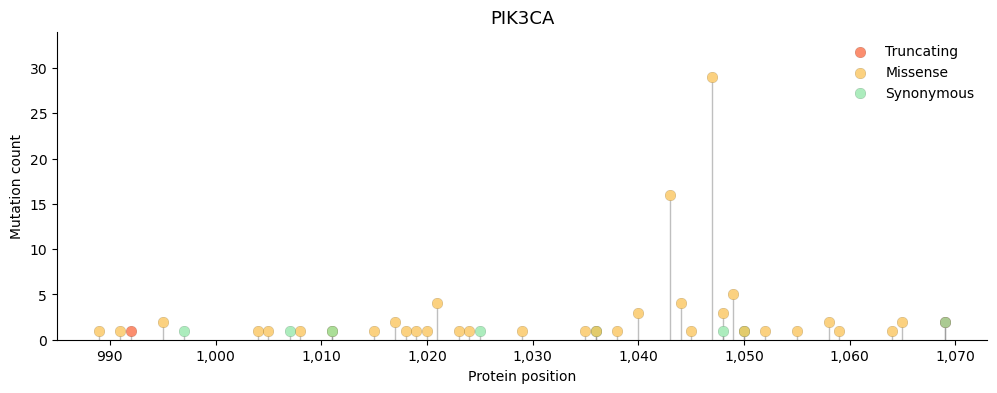

In [21]:
donor, samplesss = ('All samples', all_sample_names_dirty)
gene = "PIK3CA"

mut_count_df = counts_per_position[(counts_per_position["Gene"] == gene)
                                    & (counts_per_position["SAMPLE_ID"].isin(samplesss))]
mut_count_df = mut_count_df.groupby(by = ["Pos", "Consequence"])["Count"].sum().reset_index()

fig, ax = plt.subplots(1,1, figsize = (12,4))
plot_count_track(mut_count_df, gene_len=mut_count_df["Pos"].max(), axes=[ax], ax=0,
                 colors_dict=metrics_colors_dictionary, indel=False, alpha = 0.7)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.set_ylim(0,2.6)
ax.set_ylabel("Mutation count")

#ax.set_xlim(1294942, 1295289)
plt.legend(frameon = False,
           # loc = 'upper right'
          )


ax.set_title("PIK3CA", fontsize = 13)

ax.set_ylim(0,34)
ax.set_xlabel("Protein position")
# ax.set_ylabel("Mutation count")

xtickss = ax.get_xticks()[1:-1:1]
ax.set_xticks(xtickss)
ax.set_xticklabels([f"{int(x):,}" for x in xtickss])
# ax.set_xlim(1294942, 1295289)



plt.savefig(f"{plots_dir}/{gene}.all_samples_needle.randomized.png", bbox_inches='tight')
plt.show()
plt.close()

# Omega for PIK3CA

In [14]:
def generate_all_side_figures(sample,
                              mut_file,
                              omega_file,
                              gene_list = None,
                              tools = ["omega_trunc", "omega_mis"],
                              plotts = plots_dir,
                              ymaximum = None,
                              between_text = 1.5,
                              withinbartext_off = 1.8,
                              text_off = 0.5,
                              title  = False,
                              legendd = False
                             ):

    snvs_maf = pd.read_table(mut_file, #na_values = custom_na_values
                            )
    snvs_maf = snvs_maf[snvs_maf["TYPE"] == "SNV"].reset_index(drop = True)

    possible_genes = []

    omega_data = pd.read_table(omega_file)
    minimum_pvalue = omega_data[omega_data["pvalue"]>0]["pvalue"].min()
    omega_data = omega_data[omega_data["impact"].isin(['missense', 'truncating'])]
    if "omega_trunc" in tools :
        omega_truncating = omega_data[omega_data["impact"] == "truncating"].reset_index(drop = True)[["gene", "mutations", "dnds", "pvalue", "lower", "upper"]]
        omega_truncating.columns = ["GENE", "mutations_trunc", "omega_trunc", "pvalue", "lower", "upper"]
        omega_truncating_genes = list(pd.unique(omega_truncating["GENE"]))
        possible_genes += omega_truncating_genes

    if "omega_mis" in tools :
        omega_missense = omega_data[omega_data["impact"] == "missense"].reset_index(drop = True)[["gene", "mutations", "dnds", "pvalue", "lower", "upper"]]
        omega_missense.columns = ["GENE", "mutations_mis", "omega_mis", "pvalue", "lower", "upper"]
        omega_missense_genes = list(pd.unique(omega_missense["GENE"]))
        possible_genes += omega_missense_genes


    gene_list = list(set(possible_genes).intersection(set(gene_list)))


    # os.makedirs(f"{sample}.plots")

    for genee in gene_list:
        print(genee)
    # try :
        if "omega_trunc" in tools:
            if genee in omega_truncating_genes and genee in omega_missense_genes:
                omega_df = build_counts_from_df_complete(genee, snvs_maf, omega_truncating, omega_missense)

                fig_gene_omega = plot_omega_vertical(omega_df, ymaximum,
                                                     between_text = between_text,
                                                     withinbartext_off = withinbartext_off,
                                                     text_off = text_off,
                                                     min_pvalue = minimum_pvalue,
                                                     gene = genee if title else None,
                                                     legenddd = legendd
                                                    )
                fig_gene_omega.savefig(f"{plotts}/{genee}.{sample}.omega_side.png", bbox_inches='tight')
                plt.show()
                plt.close()
                
    # except Exception as exe:
    #     print(genee)
    #     print(exe)


In [15]:
def build_counts_from_df_complete(genee, snvs_maf, omega_truncating, omega_missense):

    trunc_omega = float(omega_truncating[omega_truncating["GENE"] == genee]["omega_trunc"].values[0])
    trunc_pvalue = float(omega_truncating[omega_truncating["GENE"] == genee]["pvalue"].values[0])

    miss_omega = float(omega_missense[omega_missense["GENE"] == genee]["omega_mis"].values[0])
    miss_pvalue = float(omega_missense[omega_missense["GENE"] == genee]["pvalue"].values[0])
    snvs_gene = snvs_maf[snvs_maf["canonical_SYMBOL"] == genee].reset_index(drop = True)


    # Calculate counts based on canonical consequences
    truncating_count = float(omega_truncating[omega_truncating["GENE"] == genee]["mutations_trunc"].values[0])
    missense_count = float(omega_missense[omega_missense["GENE"] == genee]["mutations_mis"].values[0])
    synonymous_count = snvs_gene[snvs_gene["canonical_Consequence_broader"].isin(["synonymous"])].shape[0]

    # Compute
    expected_missense = (1 - ((miss_omega - 1) / miss_omega)) * missense_count
    expected_truncating = (1 - ((trunc_omega - 1) / trunc_omega)) * truncating_count


    # Create a dataframe from the counts and expected values
    data = {
        'type': ['truncating', 'synonymous', 'missense'],
        'number_obs': [truncating_count, synonymous_count, missense_count],
        'expected': [expected_truncating, None, expected_missense],
        'omega': [trunc_omega, None, miss_omega],
        'pvalue': [trunc_pvalue, None, miss_pvalue]
    }
    df = pd.DataFrame(data)
    print(df)

    # Print the final dataframe
    return df








In [16]:
def plot_omega_vertical(df,
                        ymax = None,
                        bar_width=0.8,
                        figsize=(4, 5),
                        between_text = 1.5,
                        withinbartext_off = 1.8,
                        text_off = 0.5,
                        min_pvalue = 1e-6,
                        gene = None,
                        legenddd = True
                       ):
    consequence_order = ['truncating', 'missense', 'synonymous',]

    # Define colors
    colors = {
        'truncating': metrics_colors_dictionary["omega_trunc"],
        'missense': metrics_colors_dictionary["omega_miss"],
        'synonymous': metrics_colors_dictionary["omega_synon"]
    }

    # Filter relevant data
    df = df[df['type'].isin(consequence_order)]

    t_obs = df[df['type'] == 'truncating']['number_obs'].item()
    t_omega = df[df['type'] == 'truncating']['omega'].item()
    t_pvalue = df[df['type'] == 'truncating']['pvalue'].item()
    
    m_obs = df[df['type'] == 'missense']['number_obs'].item()
    m_omega = df[df['type'] == 'missense']['omega'].item()
    m_pvalue = df[df['type'] == 'missense']['pvalue'].item()
    
    s_obs = df[df['type'] == 'synonymous']['number_obs'].item()  # Added synonymous mutations

    # Compute x positions for bars
    spacing_factor = bar_width * 1.1  # Adjust spacing based on bar width
    x_positions = np.arange(len(consequence_order)) * spacing_factor

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # **Matplotlib Barplot**
    ax.bar(x_positions,
           [t_obs, m_obs, s_obs], 
           color=[colors[x] for x in consequence_order], 
           width=bar_width,
           edgecolor='none')

    # Overlay expected values as hatched bars (only for truncating & missense)
    for i, row in df.iterrows():
        if row['type'] != 'synonymous':  # No hatch for synonymous
            if legenddd:
                ax.bar(x_positions[consequence_order.index(row['type'])], row['expected'], 
                       color='none', edgecolor="black", hatch='////',
                       linewidth=0,
                       width=bar_width,
                       label = 'expected'
                      )
                legenddd = False
            else:
                ax.bar(x_positions[consequence_order.index(row['type'])], row['expected'], 
                       color='none', edgecolor="black", hatch='////',
                       linewidth=0,
                       width=bar_width
                      )

    # Remove top/right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Customize ticks and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels([])
    # ax.set_yticks([])
    # ax.set_yticklabels([])
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14)

    
    ax.spines['left'].set_visible(False)
    ax.set_ylabel('Number of mutations', fontsize = 14 )
    
    # Positioning text annotations
    between_text_offset = max(max(df['number_obs'].max(), df['expected'].max()) * 0.05, between_text)
    text_offset = max(max(df['number_obs'].max(), df['expected'].max()) * 0.02, text_off)
    within_bar_text_offset = max(max(df['number_obs'].max(), df['expected'].max()) * 0.06, withinbartext_off)

    for i, row in df.iterrows():
        x_pos = x_positions[consequence_order.index(row['type'])]
        y_pos = max(row['number_obs'], row['expected']) + text_offset
        y_pos_low = max(row['number_obs'], row['expected']) - within_bar_text_offset
        omega_value = t_omega if row['type'] == 'truncating' else (m_omega if row['type'] == 'missense' else None)
        p_value = t_pvalue if row['type'] == 'truncating' else (m_pvalue if row['type'] == 'missense' else None)
        color = colors[row['type']]

        # Omega annotation (above the bar) - Only for truncating/missense
        if omega_value is not None:
            excess_mutss = row["number_obs"]*((omega_value-1)/omega_value)
            ax.text(x_pos, y_pos + between_text_offset,
                    # rf'$dN/dS$ = {omega_value:.2f}',
                    rf'dNdS={omega_value:.2f}',
                    fontsize=13, ha='center', va='bottom',
                    # color=color
                    color='black'
                   )

            # P-value annotation (below omega)
            ax.text(x_pos, y_pos,
                    f'$p$<{min_pvalue:.1e}' if p_value < min_pvalue else (f'$p$={p_value:.1e}' if p_value < 0.01 else f'$p$={p_value:.2f}'),
                    fontsize=11, ha='center', va='bottom',
                    # color=color
                    color='black'
                   )

            # Add excess mutations in bar
            if excess_mutss >= 1:
                ax.text(x_pos, y_pos_low,
                        f'{excess_mutss:.0f}',
                        fontsize=13, ha='center', va='bottom', color= 'black')

            
        else:
            mutations = row['number_obs']
            ax.text(x_pos,
                    y_pos,
                    #y_pos_low,
                    # rf'$dN/dS$ = {omega_value:.2f}',
                    rf'{mutations:.0f}',
                    fontsize=13, ha='center', va='bottom', color='gray')
        

    plt.legend(frameon=False, bbox_to_anchor = (0.8,1), fontsize = 13)

    if ymax is not None:
        plt.ylim(0,ymax)
        
    if gene is not None:
        plt.title(gene, pad = 30, fontsize = 16)
    
    return fig


all_samples


/tmp/ipykernel_2051283/483463610.py:15: DtypeWarning: Columns (49,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  snvs_maf = pd.read_table(mut_file, #na_values = custom_na_values
/tmp/ipykernel_2051283/537733612.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14)


PIK3CA
         type  number_obs   expected     omega    pvalue
0  truncating         3.0   4.247788  0.706250  0.529183
1  synonymous         9.0        NaN       NaN       NaN
2    missense        94.0  32.715655  2.873242  0.000000


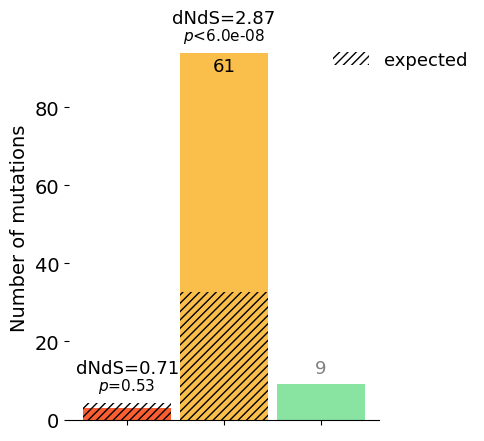

In [17]:
# for sampleee in repeated_samples:
for sampleee in ['all_samples']:
    sample_name_ = sampleee
    mut_filee    = f"{deepcsa_run_dir}/clean_somatic/{sample_name_}.somatic.mutations.tsv"
    omega_filee  = f"{deepcsa_run_dir}/omegagloballoc/output_mle.{sample_name_}.global_loc.tsv"
    print(sampleee)
    
    generate_all_side_figures(sample_name_,
                              mut_filee,
                              omega_filee,
                              ["PIK3CA"],
                              # gene_order_positive_selection,
                              plotts= plots_dir,
                              # ymaximum=40,
                              # between_text = 1.5,
                              # withinbartext_off = 1.8,
                              # text_off = 0.5
                              title = False,
                              legendd = True
                              )



# TO BE REMOVED

In [19]:
maf_df = pd.read_table(maf_file)
maf_clean = maf_df[(maf_df["canonical_SYMBOL"].isin(panel_all_genes)) 
                                & (maf_df["TYPE"] == 'SNV')
                                & (maf_df["canonical_SYMBOL"] == 'PIK3CA')
                                & (~maf_df["FILTER.not_in_exons"])
                                & (maf_df['canonical_Protein_position'] != '-')
                                ].reset_index(drop = True)
maf_clean['canonical_Protein_position'] = maf_clean['canonical_Protein_position'].astype(int)

counts_per_position_maf = maf_clean.groupby(by = ["SAMPLE_ID", "canonical_SYMBOL", 'canonical_Consequence_broader', 'canonical_Protein_position'])['ALT_DEPTH'].size().to_frame('Count').reset_index()
counts_per_position_maf.columns = ["SAMPLE_ID", 'Gene', 'Consequence', 'Pos', 'Count']
counts_per_position_maf.head()

/tmp/ipykernel_2051283/779772914.py:1: DtypeWarning: Columns (49,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  maf_df = pd.read_table(maf_file)


,SAMPLE_ID,Gene,Consequence,Pos,Count
0,P19_0001_BDO_01,PIK3CA,missense,1047,1
1,P19_0001_BTR_01,PIK3CA,missense,1047,1
2,P19_0002_BDO_01,PIK3CA,missense,1011,1
3,P19_0002_BDO_01,PIK3CA,missense,1047,1
4,P19_0002_BTR_01,PIK3CA,missense,1024,1


In [26]:
def generate_all_side_figures(sample,
                              mut_file,
                              omega_file,
                              gene_list = None,
                              tools = ["omega_mis"],
                              plotts = plots_dir
                             ):
    
    snvs_maf = pd.read_table(mut_file)
    snvs_maf = snvs_maf[snvs_maf["TYPE"] == "SNV"].reset_index(drop = True)

    possible_genes = []

    omega_data = pd.read_table(omega_file)
    minimum_pvalue = omega_data[omega_data["pvalue"]>0]["pvalue"].min()
    omega_data = omega_data[omega_data["impact"].isin(['missense'])]
    if "omega_mis" in tools :
        omega_missense = omega_data[omega_data["impact"] == "missense"].reset_index(drop = True)[["gene", "mutations", "dnds", "pvalue", "lower", "upper"]]
        omega_missense.columns = ["GENE", "mutations_mis", "omega_mis", "pvalue", "lower", "upper"]
        omega_missense_genes = list(pd.unique(omega_missense["GENE"]))
        possible_genes += omega_missense_genes


    gene_list = list(set(possible_genes).intersection(set(gene_list)))
    print(gene_list)


    for genee in gene_list:
        print(genee)
        # try :
        if "omega_mis" in tools:
            if genee in omega_missense_genes:
                omega_df = build_counts_from_df_complete(genee, snvs_maf, pd.DataFrame(), omega_missense)

                # fig_gene_omega = plot_omega_side_complete(omega_df)
                fig_gene_omega = plot_omega_vertical(omega_df, min_pvalue= minimum_pvalue)
                fig_gene_omega.savefig(f"{plotts}/{genee}.{sample}.omega_side.png", bbox_inches='tight')
                plt.show()
                plt.close()

        # except Exception as exe:
        #     print(genee)
        #     print(exe)


In [14]:
def build_counts_from_df_complete(genee, snvs_maf, omega_truncating, omega_missense):

    miss_omega = float(omega_missense[omega_missense["GENE"] == genee]["omega_mis"].values[0])
    miss_pvalue = float(omega_missense[omega_missense["GENE"] == genee]["pvalue"].values[0])
    snvs_gene = snvs_maf[snvs_maf["canonical_SYMBOL"] == genee].reset_index(drop = True)

    # Calculate counts based on canonical consequences
    missense_count = float(omega_missense[omega_missense["GENE"] == genee]["mutations_mis"].values[0])
    synonymous_count = snvs_gene[snvs_gene["canonical_Consequence_broader"].isin(["synonymous"])].shape[0]

    # Compute
    expected_missense = (1 - ((miss_omega - 1) / miss_omega)) * missense_count

    # Create a dataframe from the counts and expected values
    data = {
        'type': [ 'synonymous', 'missense'],
        'number_obs': [ synonymous_count, missense_count],
        'expected': [None, expected_missense],
        'omega': [ None, miss_omega],
        'pvalue': [ None, miss_pvalue]
    }
    df = pd.DataFrame(data)

    # Print the final dataframe
    return df


In [16]:
def plot_omega_vertical(df, bar_width=0.2, figsize=(1.5, 5),
                        min_pvalue = 1e-6,

                       ):
    consequence_order = ['missense']

    # Define colors
    colors = {
        'missense': metrics_colors_dictionary["omega_miss_tert"],
        'synonymous': metrics_colors_dictionary["omega_synon_tert"]
    }

    # Filter relevant data
    df = df[df['type'].isin(consequence_order)]
    
    m_obs = df[df['type'] == 'missense']['number_obs'].item()
    m_omega = df[df['type'] == 'missense']['omega'].item()
    m_pvalue = df[df['type'] == 'missense']['pvalue'].item()
    
    s_obs = 0 #df[df['type'] == 'synonymous']['number_obs'].item()  # Added synonymous mutations

    # Compute x positions for bars
    spacing_factor = bar_width * 1.1  # Adjust spacing based on bar width
    x_positions = np.arange(len(consequence_order)) * spacing_factor

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # **Matplotlib Barplot**
    ax.bar(x_positions,
           [m_obs], 
           color=[colors[x] for x in consequence_order], 
           width=bar_width,
           edgecolor='none')

    # Overlay expected values as hatched bars (only for truncating & missense)
    for i, row in df.iterrows():
        if row['type'] != 'synonymous':  # No hatch for synonymous
            ax.bar(x_positions[consequence_order.index(row['type'])], row['expected'], 
                   color='none', edgecolor="black", hatch='////',
                   linewidth=0,
                   width=bar_width)

    # Remove top/right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Customize ticks and labels
    ax.set_xticks(x_positions)
    # ax.set_xticklabels(["Mutations seen\nin tumors"])
    ax.set_xticklabels([])
    # ax.set_yticks([])
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14)

    
    ax.spines['left'].set_visible(False)
    ax.set_ylabel('Number of mutations', fontsize = 14 )

    # Positioning text annotations
    between_text_offset = max(df['number_obs']) * 0.05
    text_offset = max(df['number_obs']) * 0.02
    within_bar_text_offset = max(df['number_obs']) * 0.06

    for i, row in df.iterrows():
        x_pos = x_positions[consequence_order.index(row['type'])]
        y_pos = row['number_obs'] + text_offset
        y_pos_low = row['number_obs'] - within_bar_text_offset
        omega_value = m_omega if row['type'] == 'missense' else None
        p_value = m_pvalue if row['type'] == 'missense' else None
        
        # color = colors[row['type']]
        color = 'black'

        # Omega annotation (above the bar) - Only for truncating/missense
        if omega_value is not None:
            ax.text(x_pos, y_pos + between_text_offset,
                    # rf'$dN/dS$ = {omega_value:.2f}',
                    rf'dNdS={omega_value:.2f}',
                    fontsize=13, ha='center', va='bottom', color=color)

            # P-value annotation (below omega)
            ax.text(x_pos, y_pos,
                    f'$p$<{min_pvalue:.1e}' if p_value < min_pvalue else (f'$p$={p_value:.1e}' if p_value < 0.01 else f'$p$={p_value:.2f}'),
                    fontsize=11, ha='center', va='bottom', color=color)

            # Add excess mutations in bar
            ax.text(x_pos, y_pos_low,
                    f'{row["number_obs"]*((omega_value-1)/omega_value) :.0f}',
                    fontsize=11, ha='center', va='bottom', color= 'black')

            
        else:
            mutations = row['number_obs']
            ax.text(x_pos,
                    y_pos,
                    #y_pos_low,
                    # rf'$dN/dS$ = {omega_value:.2f}',
                    rf'{mutations:.0f}',
                    fontsize=11, ha='center', va='bottom', color='gray')
        

    plt.legend(loc='best', frameon=False)
    return fig


all_samples


/tmp/ipykernel_1937781/607900508.py:9: DtypeWarning: Columns (49,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  snvs_maf = pd.read_table(mut_file)
/tmp/ipykernel_1937781/405514552.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14)
/tmp/ipykernel_1937781/405514552.py:102: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', frameon=False)


['TERTpromoter']
TERTpromoter


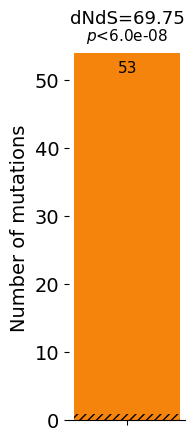

In [17]:
# for sampleee in repeated_samples:
for sampleee in ['all_samples']:
    sample_name_ = sampleee
    mut_filee    = f"{deepcsa_run_dir}/somaticmutations/{sample_name_}.somatic.mutations.tsv"
    omega_filee  = f"{deepcsa_run_dir}/omegagloballoc/output_mle.{sample_name_}.global_loc.tsv"
    print(sampleee)
    
    generate_all_side_figures(sample_name_,
                              mut_filee,
                              omega_filee,
                              ["TERTpromoter"],
                              # gene_order_positive_selection,
                              plotts= plots_dir
                             )
